<a href="https://colab.research.google.com/github/ElenaGordienko1/ML/blob/main/ML4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ⏰ Домашнее задание

- 1. Выбрать пременную для задачи бинарной классификации (назовем это x_binary, y_binary) и выбрать пременные для задачи мультиклассовой классификации (назовем это x_multi, y_multi)

p.s. если использовали произвольную пременную для binary, multiclassification - не зывбаем выбрасывать из X изначальную переменную

- 2. Решить задачу классификации с использованием кросс валидации, оценить метрики качства: accuracy, precision, recall (включая classification report).
  - 2.1. Используя опыт прошлых работ, попробуйте использовать лучшие признаки для решения задачи

- 3. Для обоих задач побороться с дисбалансом классов следующими техниками:
  - oversampling (например, SMOTE)
  - или undersampling.

Для oversampling и undersampling используйте (https://imbalanced-learn.org/)
Опишите полученный результат

Самый простой пример (желательно не использовать рандом)
```
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
```

- 4. Обучить дерево принятия решений с использованием кросс-валидации (Stratify K-fold и/или StratifyRandomShuffle)  для ```oversampling``` и ```undersampling``` (в задачи мультиклассовой классификации), оценить метрики и описать результат.


## 1. Бинарная классификация

In [ ]:
!pip install pandas scikit-learn seaborn scipy

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Загрузка набора данных
df = pd.read_csv('/content/heart_disease.csv')

df['old_and_sick'] = np.where(df['age'] >= 50, 1, 0)
df.old_and_sick = df.old_and_sick.astype('category')
df['sex'] = df['sex'].astype('category')

Y = df['old_and_sick'] # выбираем целевую переменную (категориальную)
X = df.drop('old_and_sick', axis=1) # переменные для проверки влияния

# В моем случае я дропаю базовую переменную, а не только. Y
X = X.drop('age', axis=1)
df.drop('age', axis=1).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270 entries, 0 to 269
Data columns (total 14 columns):
 #   Column                                Non-Null Count  Dtype   
---  ------                                --------------  -----   
 0   sex                                   270 non-null    category
 1   chest pain type                       270 non-null    int64   
 2   resting blood pressure                270 non-null    int64   
 3   serum cholestoral in mg/dl            270 non-null    int64   
 4   fasting blood sugar > 120 mg/dl       270 non-null    int64   
 5   resting electrocardiographic results  270 non-null    int64   
 6   maximum heart rate achieved           270 non-null    int64   
 7   exercise induced angina               270 non-null    int64   
 8   oldpeak                               270 non-null    float64 
 9   slope of peak                         270 non-null    int64   
 10  number of major vessels               270 non-null    int64   
 11  thal  

In [2]:
# Создаем копию данных
category_columns: list[str] = X.select_dtypes(include=['category']).columns # собираем колонки помеченные как category

# Применяем One-Hot Encoding
X = pd.get_dummies(X, columns=category_columns,drop_first=True) # drop_first=True позволяет избежать мультиколлинеарности, удаляя первый уровень категориальной переменной.

### Обучаем логистическую регрессию

In [8]:
from sklearn.model_selection import cross_val_score

def train_and_evaluate(X, Y):
    # Разделение данных на обучающую и тестовую выборки
    X_train, X_test, Y_train, Y_test = train_test_split(
        X, Y, test_size=0.2, random_state=42, stratify=Y)

    # Инициализация модели
    model = LogisticRegression(max_iter=1000)

    # Обучение модели
    model.fit(X_train, Y_train)

    # Предсказания на обучающей выборке
    Y_train_pred = model.predict(X_train)
    train_accuracy = accuracy_score(Y_train, Y_train_pred)

    # Предсказания на тестовой выборке
    Y_test_pred = model.predict(X_test)
    test_accuracy = accuracy_score(Y_test, Y_test_pred)


    # Классификационный отчет

    print("\nClassification Report:\n",classification_report(Y_test, Y_test_pred))

    return model


In [9]:
train_and_evaluate(X, Y)


Classification Report:
               precision    recall  f1-score   support

           0       0.56      0.31      0.40        16
           1       0.76      0.89      0.82        38

    accuracy                           0.72        54
   macro avg       0.66      0.60      0.61        54
weighted avg       0.70      0.72      0.70        54



LogisticRegression(max_iter=1000)


classification_report:

Precision:

0 (0.56) — 56% предсказанных значений, как класс 0, действительно относятся к классу 0.

1 (0.76) — 76% предсказанных значений,как класс 1, действительно относятня к классу 1.

Recall:

0 (0.31) — модель нашла 31% всех значений, которые относятся к классу 0.

1 (0.89) — модель нашла 89% всех,которые относятся к классу 1.

F1-score:

0 класс (0.40), 1 класс (0.82) — баланс Precision и Recall для каждого класса.

Accuracy = 0.72 — 72% всех предсказаний правильны.

###Создание дисбаланса

In [10]:
Y.value_counts()

,count
old_and_sick,
1,191
0,79


In [12]:
from sklearn.utils import resample

# Объединяем X и y для удобства
data = pd.concat([X, Y], axis=1)

# Разделяем на классы
majority = data[data['old_and_sick'] == 0]
minority = data[data['old_and_sick'] == 1]

# Уменьшаем количество экземпляров класса 1
minority_downsampled = resample(minority,
                                replace=False,
                                n_samples=int(len(majority)*0.1),
                                random_state=42)

# Объединяем обратно
data_disbalanced = pd.concat([majority, minority_downsampled])

# Новые X и y
X_disbalanced = data_disbalanced.drop('old_and_sick', axis=1)
y_disbalanced = data_disbalanced['old_and_sick']

In [13]:
print(y_disbalanced.value_counts())


old_and_sick
0    79
1     7
Name: count, dtype: int64


OVERSAMLER

In [20]:
from imblearn.over_sampling import RandomOverSampler
rus = RandomOverSampler(random_state=42)
X_res, y_res = rus.fit_resample(X_disbalanced, y_disbalanced)


In [21]:
y_res.value_counts()

,count
old_and_sick,
0,79
1,79


###Создание дерева

In [23]:
from sklearn.tree import DecisionTreeClassifier
# Разделяем данные
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

# Обучаем модель
tree_model = DecisionTreeClassifier(random_state=42, max_depth=10)
tree_model.fit(X_train, y_train)

# Предсказания
y_pred = tree_model.predict(X_test)

In [24]:
from sklearn.metrics import classification_report

print("\nClassification Report:\n", classification_report(y_test, y_pred))



Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.37      0.43        27
           1       0.72      0.81      0.77        54

    accuracy                           0.67        81
   macro avg       0.61      0.59      0.60        81
weighted avg       0.65      0.67      0.65        81



In [25]:
accuracy_score(y_test, y_pred)

0.6666666666666666

In [26]:
from sklearn.metrics import balanced_accuracy_score
balanced_accuracy_score(y_test, y_pred) # ну такое


0.5925925925925926

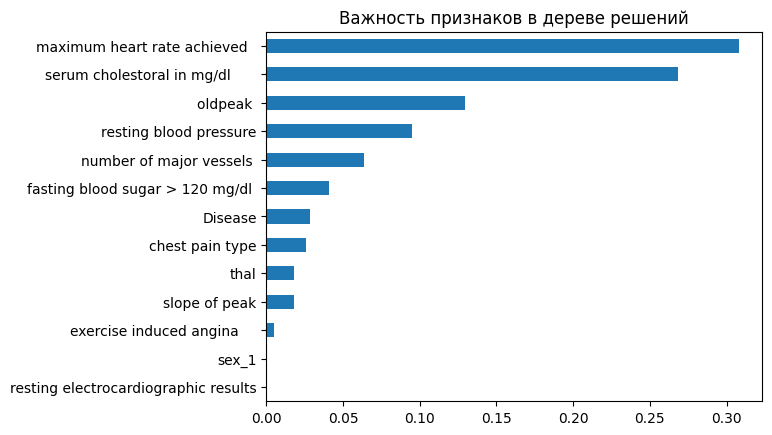

In [27]:
import matplotlib.pyplot as plt

feature_importances = pd.Series(tree_model.feature_importances_, index=X.columns)
feature_importances.sort_values().plot(kind='barh')
plt.title('Важность признаков в дереве решений')
plt.show()


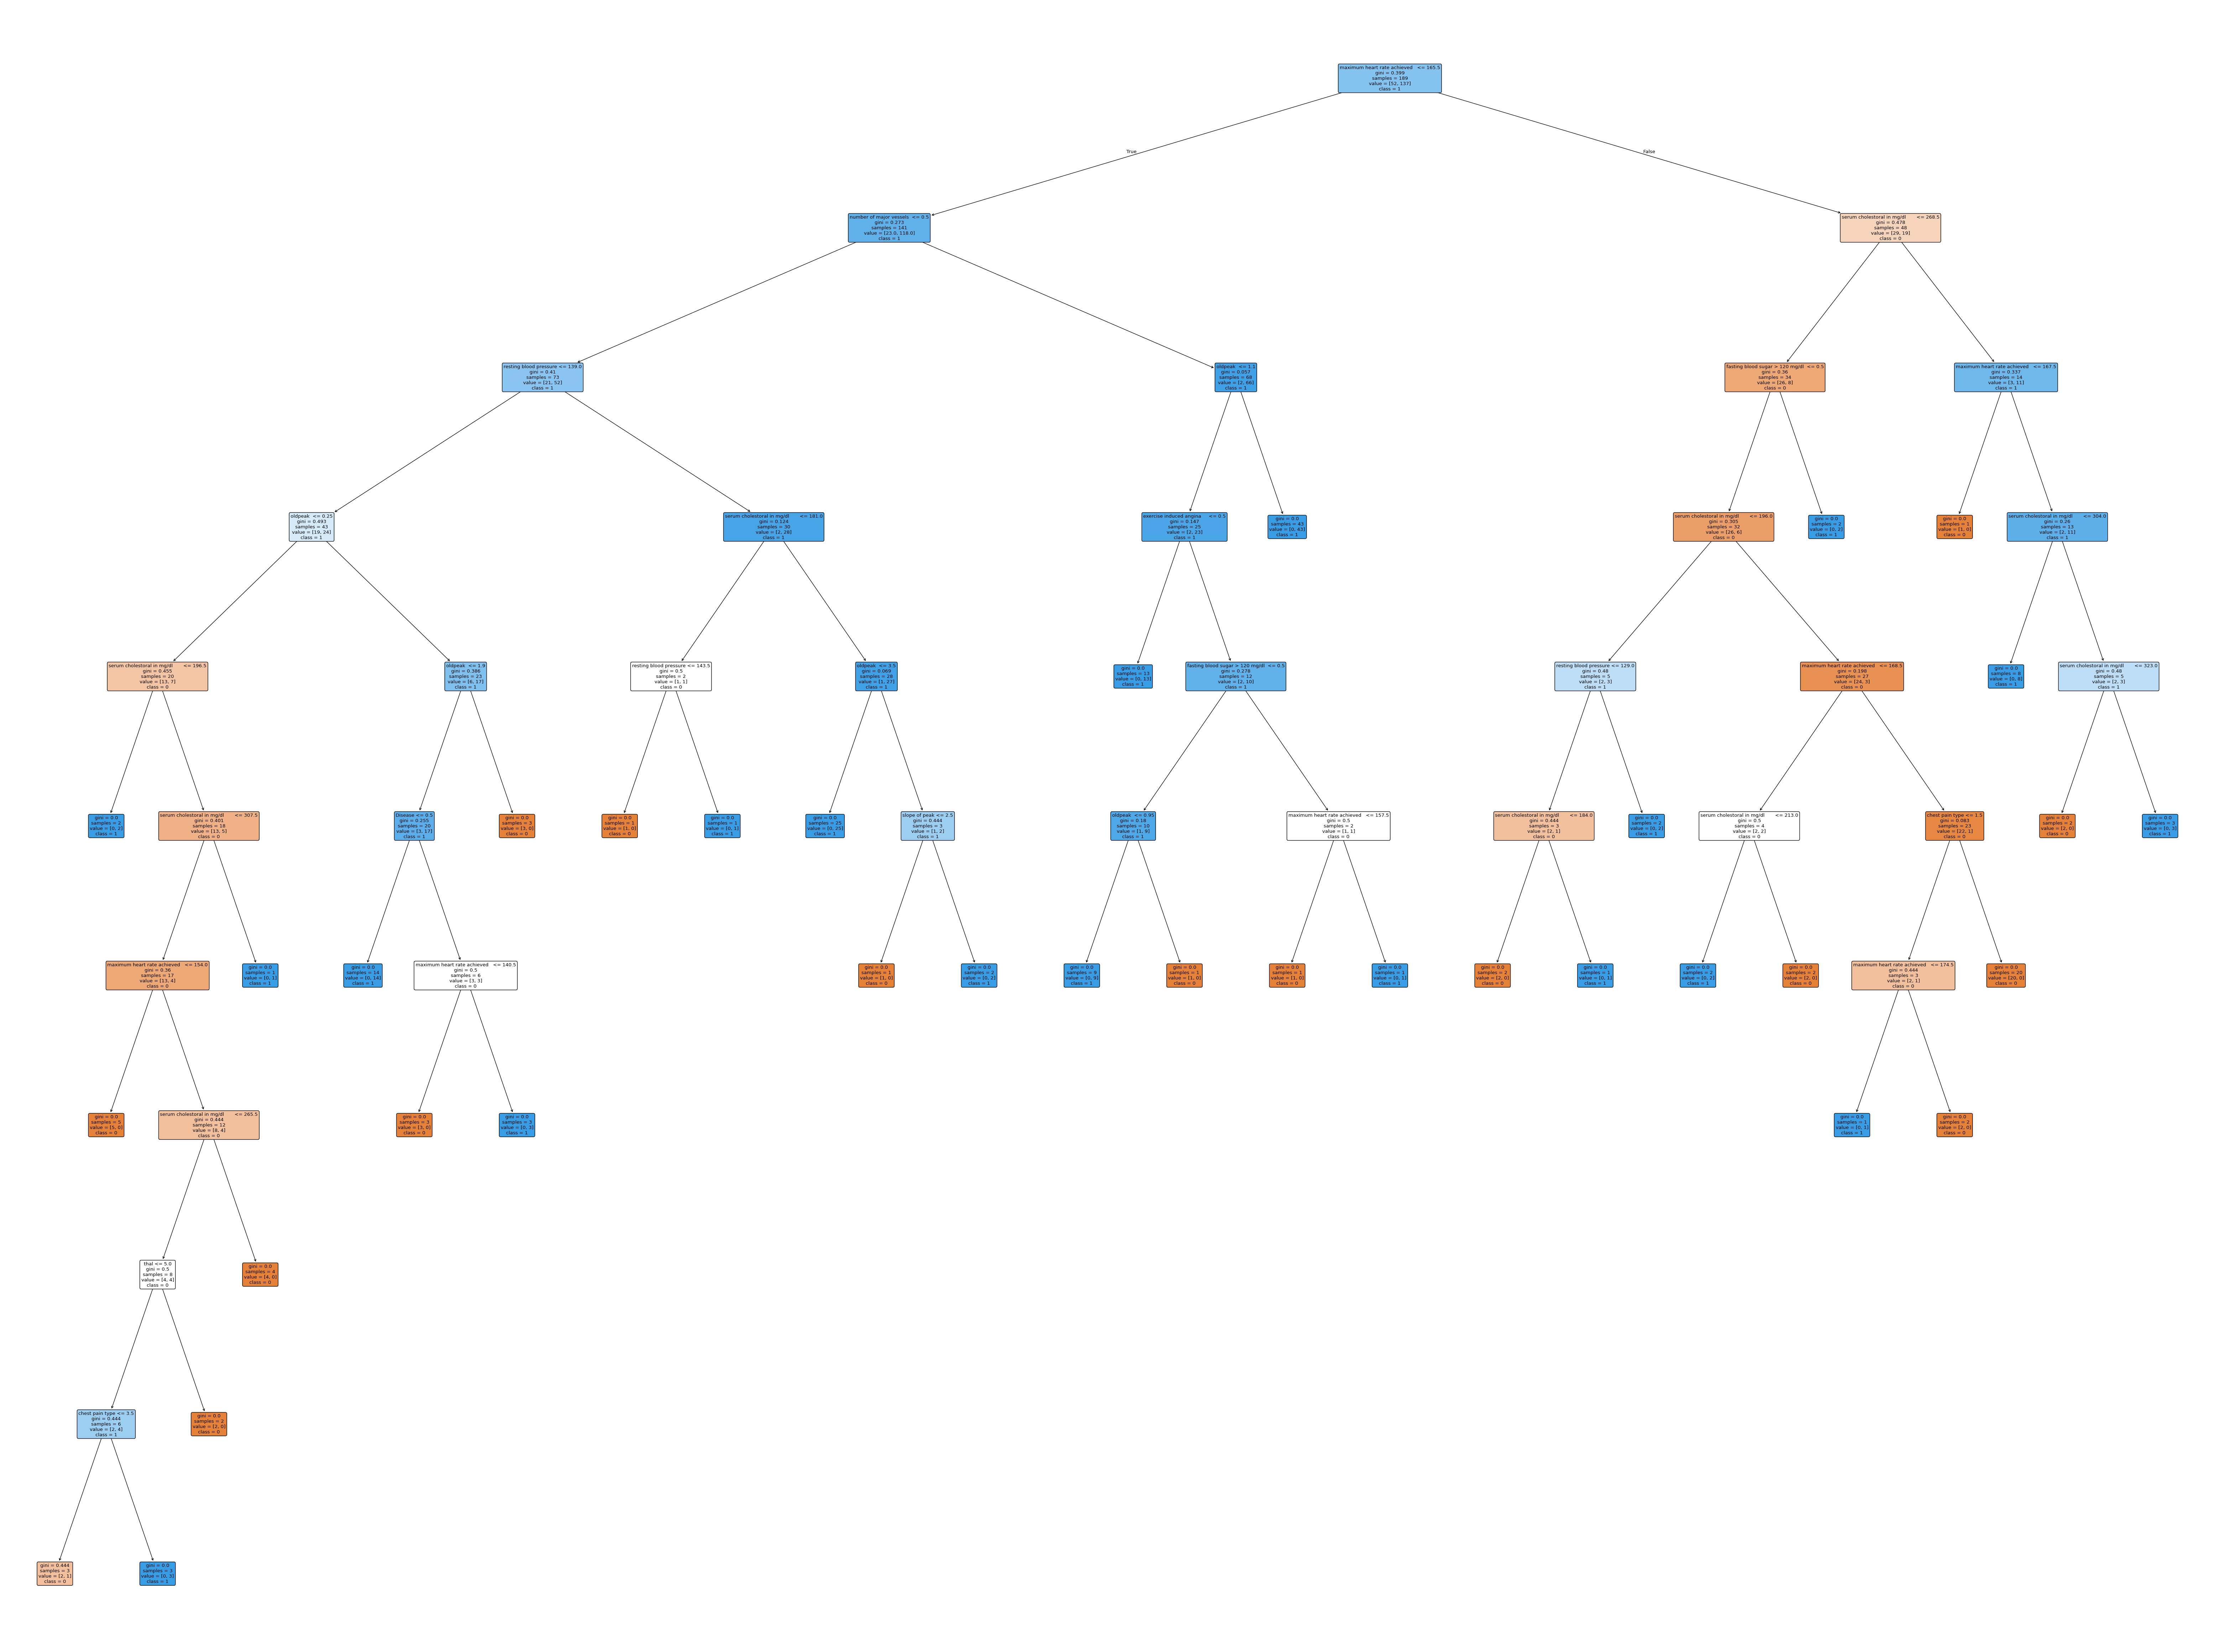

In [29]:
from sklearn.tree import plot_tree
# Визуализируем дерево решений
plt.figure(figsize=(80, 60))
plot_tree(tree_model, feature_names=X.columns, class_names=[str(item) for item in sorted(Y.unique())], filled=True, rounded=True)
plt.show()


## 2. Мультиклассовая классификация

In [36]:
y_multi = df['age']

X_multi = df.drop(['age', 'old_and_sick'], axis=1)

In [37]:
# Создаем копию данных
category_columns: list[str] = X_multi.select_dtypes(include=['category']).columns # собираем колонки помеченные как category

# Применяем One-Hot Encoding
X_multi = pd.get_dummies(X_multi, columns=category_columns,drop_first=True) # drop_first=True позволяет избежать мультиколлинеарности, удаляя первый уровень категориальной переменной.


### Обучаем логистическую регрессию

In [61]:
# Разделяем данные
X_train_multi, X_test_multi, y_train_multi, y_test_multi = train_test_split(X_multi, y_multi, test_size=0.3, random_state=42)

# Обучаем модель
model = LogisticRegression(max_iter=1000)
model.fit(X_train_multi, y_train_multi)

# Предсказания
y_pred_multi = model.predict(X_test_multi)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [62]:
from sklearn.metrics import classification_report

print("\nClassification Report:\n", classification_report(y_test_multi, y_pred_multi))


Classification Report:
               precision    recall  f1-score   support

          35       0.00      0.00      0.00         1
          37       0.00      0.00      0.00         1
          39       0.00      0.00      0.00         1
          40       0.00      0.00      0.00         1
          41       0.00      0.00      0.00         3
          42       0.00      0.00      0.00         3
          43       0.00      0.00      0.00         3
          44       0.25      0.25      0.25         4
          45       0.00      0.00      0.00         3
          46       0.00      0.00      0.00         2
          47       0.00      0.00      0.00         0
          48       0.00      0.00      0.00         2
          49       0.00      0.00      0.00         3
          50       0.00      0.00      0.00         1
          51       0.00      0.00      0.00         4
          52       0.00      0.00      0.00         3
          53       0.00      0.00      0.00         1
  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_

###OVERSAMPLING

In [63]:
y_multi.value_counts()

,count
age,
54,16
58,15
51,12
57,12
59,12
60,12
52,11
62,11
44,10


###Обучить дерево принятия решений для oversampling

In [64]:
from imblearn.over_sampling import RandomOverSampler
rus = RandomOverSampler(random_state=42)
X_res, y_res = rus.fit_resample(X_multi, y_multi)


In [65]:
print(y_res.value_counts())


age
70    16
58    16
37    16
50    16
42    16
62    16
49    16
52    16
45    16
41    16
76    16
39    16
35    16
55    16
34    16
38    16
69    16
68    16
77    16
66    16
51    16
67    16
54    16
57    16
64    16
74    16
65    16
56    16
59    16
60    16
63    16
53    16
44    16
61    16
71    16
46    16
40    16
48    16
43    16
47    16
29    16
Name: count, dtype: int64


In [66]:
from sklearn.tree import DecisionTreeClassifier
# Разделяем данные
X_train_multi, X_test_multi, y_train_multi, y_test_multi = train_test_split(X_res, y_res, test_size=0.3, random_state=42)

# Обучаем модель
tree_model = DecisionTreeClassifier(random_state=42, max_depth=10)
tree_model.fit(X_train_multi, y_train_multi)

# Предсказания
y_pred_multi = tree_model.predict(X_test_multi)

In [67]:
from sklearn.metrics import classification_report

print("\nClassification Report:\n", classification_report(y_test_multi, y_pred_multi))



Classification Report:
               precision    recall  f1-score   support

          29       1.00      1.00      1.00         5
          34       1.00      0.40      0.57         5
          35       0.20      0.80      0.32         5
          37       0.27      1.00      0.42         4
          38       1.00      1.00      1.00         6
          39       1.00      0.50      0.67         4
          40       0.80      1.00      0.89         4
          41       0.00      0.00      0.00         4
          42       0.00      0.00      0.00         6
          43       0.00      0.00      0.00         3
          44       0.00      0.00      0.00         3
          45       1.00      0.25      0.40         4
          46       0.50      0.33      0.40         6
          47       0.17      1.00      0.29         3
          48       0.50      0.86      0.63         7
          49       1.00      0.33      0.50         3
          50       0.00      0.00      0.00         6
  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


classification_report:

Accuracy = 0.41 — 41% всех предсказаний правильны.

Macro avg — усредненное качество модели по всем классам 36%

Weighted avg — качество модели по количеству примеров каждого класса 38%

In [49]:
accuracy_score(y_test_multi, y_pred_multi)


0.41116751269035534

In [50]:
from sklearn.metrics import balanced_accuracy_score
balanced_accuracy_score(y_test_multi, y_pred_multi)


0.39126016260162594

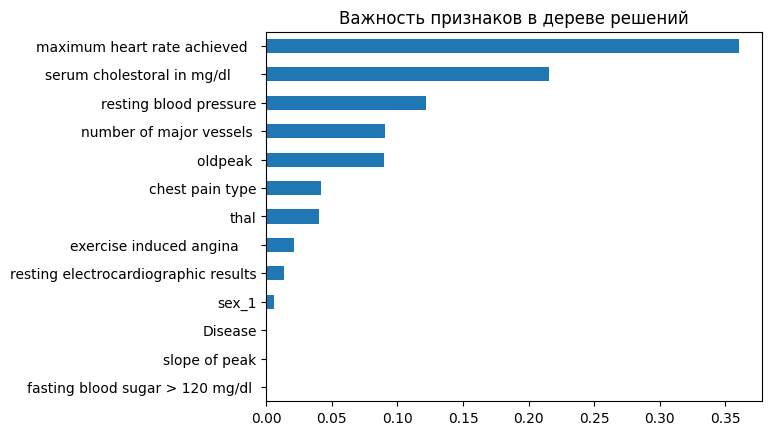

In [54]:
import matplotlib.pyplot as plt

feature_importances = pd.Series(tree_model.feature_importances_, index=X_res.columns)
feature_importances.sort_values().plot(kind='barh')
plt.title('Важность признаков в дереве решений')
plt.show()


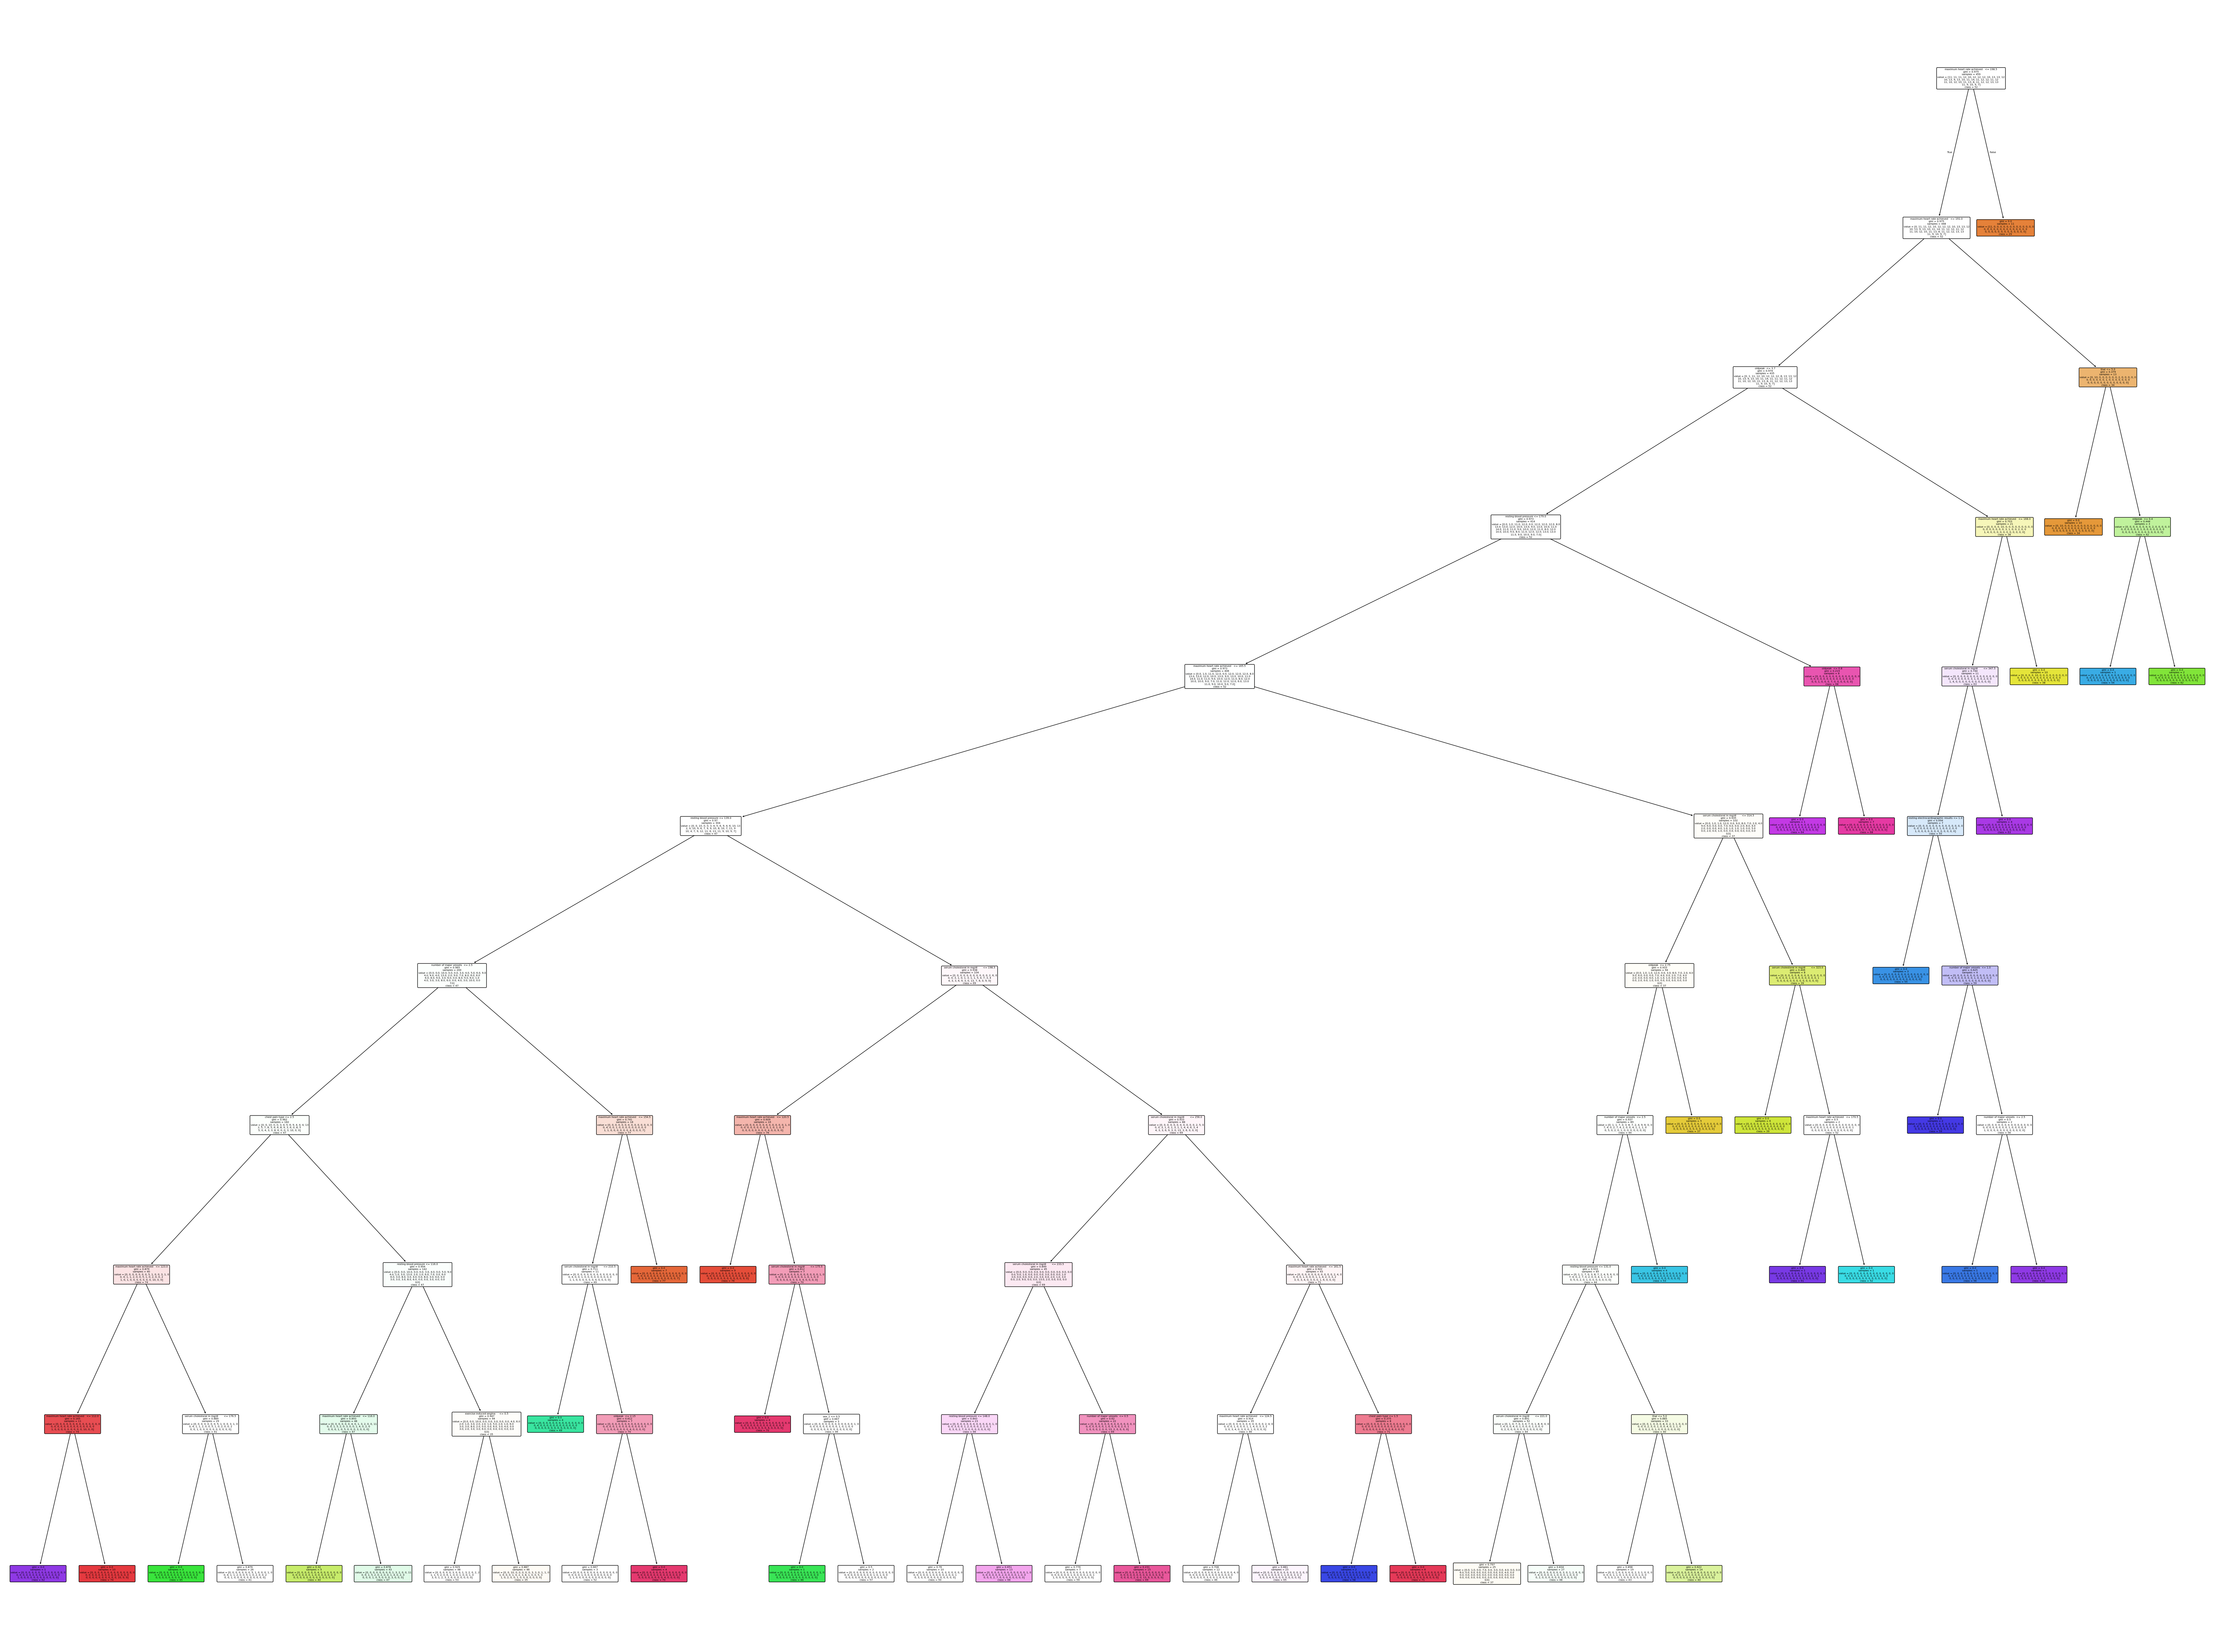

In [56]:
from sklearn.tree import plot_tree
# Визуализируем дерево решений
plt.figure(figsize=(80, 60))
plot_tree(tree_model, feature_names=X_res.columns, class_names=[str(item) for item in sorted(y_res.unique())], filled=True, rounded=True)
plt.show()
